# Library Imports

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from pymc import math as pm_math
from scipy.stats import halfnorm, skewnorm

# Model Specification
## Simulated Data
$$ X \sim N(1,1) $$
$$ U \sim HN(0, \sigma_u^2) $$
$$ Y \sim SN(\xi, \sigma_v^2, \lambda)$$
$$ \xi = \alpha + \beta X - U $$
$$ \alpha = 5, \beta = 2 $$
## Priors
$$ \alpha \sim N(\mu_\alpha, \sigma_\alpha^2) $$
$$ \beta \sim N(\mu_\beta, \sigma_\beta^2) $$
$$ \sigma_v^2 \sim IG(\alpha_v, \beta_v) $$
$$ \sigma_u^2 \sim IG(\alpha_u, \beta_u) $$
$$ \lambda \sim TN(\mu_\lambda, \sigma_\lambda^2; a, b)$$


# Simulate Data

In [18]:
np.random.seed(123)

# Parameters 
n = 50
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -0.5

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

In [3]:
data.head()

X         Y
0 -0.085631  3.444481
1  1.997345  6.248438
2  1.282978  3.450195
3 -0.506295 -1.071731
4  0.421400  7.164607

# Simulation 1


In [21]:
with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.InverseGamma('sigma_u', alpha=4, beta=3)
    sigma_v = pm.InverseGamma('sigma_v', alpha=2, beta=3)
    lam = pm.Normal('lam', mu=-5, sigma=5)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.99, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    3.25  0.99    1.68     5.17       0.03     0.02   1144.56   1964.86   
beta     2.34  0.18    2.02     2.68       0.00     0.00   4796.19   5187.79   
lam      1.36  2.13   -2.19     5.27       0.09     0.07    569.18   1139.57   
sigma_u  0.98  0.44    0.29     1.77       0.02     0.01    380.10   1300.00   
sigma_v  1.77  0.34    1.20     2.42       0.01     0.00   2588.29   3622.06   
U[0]     0.62  0.54    0.00     1.59       0.01     0.01   1865.86   2696.00   
U[1]     1.06  0.84    0.00     2.59       0.03     0.02    622.59   2117.88   
U[2]     1.44  1.09    0.00     3.38       0.05     0.02    465.52   1777.70   
U[3]     1.57  1.19    0.00     3.69       0.06     0.02    473.55   1589.40   
U[4]     0.42  0.39    0.00     1.13       0.01     0.01   2800.70   3116.71   
U[5]     0.67  0.57    0.00     1.72       0.01     0.01   1609.50   2840.74   
U[6]     0.48  0.43    0.00     1.27       0.01     0.01   2514.56   2584.20   
U[7]     0.82  0.67    0.00     2.04       0.02     0.01    982.02   2501.35   
U[8]     0.55  0.50    0.00     1.45       0.01     0.01   2171.69   2845.45   
U[9]     0.71  0.59    0.00     1.79       0.02     0.01   1141.80   1878.56   
U[10]    0.61  0.52    0.00     1.55       0.01     0.01   1874.45   2275.41   
U[11]    0.75  0.62    0.00     1.90       0.02     0.01   1130.87   2590.95   
U[12]    0.68  0.58    0.00     1.77       0.01     0.01   1672.24   3077.78   
U[13]    0.57  0.49    0.00     1.45       0.01     0.01   2446.33   3185.40   
U[14]    0.61  0.53    0.00     1.61       0.01     0.01   1823.10   2924.09   
U[15]    0.79  0.65    0.00     1.99       0.02     0.01    957.34   2755.47   
U[16]    1.28  0.99    0.00     3.05       0.04     0.02    534.51   1729.30   
U[17]    0.50  0.44    0.00     1.33       0.01     0.01   2353.51   2559.47   
U[18]    0.98  0.76    0.00     2.35       0.03     0.01    684.31   1790.47   
U[19]    0.67  0.57    0.00     1.71       0.01     0.01   1494.15   2531.98   
U[20]    0.49  0.44    0.00     1.28       0.01     0.01   2260.10   2397.11   
U[21]    0.69  0.58    0.00     1.75       0.02     0.01   1341.55   2414.16   
U[22]    0.77  0.63    0.00     1.92       0.02     0.01   1081.12   2223.90   
U[23]    0.76  0.63    0.00     1.93       0.02     0.01   1158.59   2844.25   
U[24]    0.82  0.68    0.00     2.06       0.02     0.01    870.99   1697.35   
U[25]    1.04  0.81    0.00     2.50       0.03     0.02    622.91   1995.07   
U[26]    0.59  0.52    0.00     1.55       0.01     0.01   1732.89   2433.65   
U[27]    0.61  0.52    0.00     1.55       0.01     0.01   1627.94   3093.09   
U[28]    0.71  0.61    0.00     1.82       0.02     0.01   1251.03   2355.92   
U[29]    0.74  0.62    0.00     1.88       0.02     0.01   1053.33   1907.07   
U[30]    0.78  0.63    0.00     1.93       0.02     0.01    960.99   2393.82   
U[31]    0.89  0.73    0.00     2.25       0.03     0.01    811.98   2164.71   
U[32]    1.18  0.92    0.00     2.84       0.04     0.02    540.12   1927.97   
U[33]    0.66  0.56    0.00     1.70       0.01     0.01   1505.25   2397.53   
U[34]    0.75  0.63    0.00     1.88       0.02     0.01   1226.10   2033.02   
U[35]    1.61  1.20    0.00     3.77       0.06     0.03    431.04   1440.65   
U[36]    0.55  0.49    0.00     1.46       0.01     0.01   2261.77   2542.28   
U[37]    1.35  1.03    0.00     3.23       0.05     0.02    513.07   1911.20   
U[38]    1.13  0.87    0.00     2.70       0.04     0.02    612.98   1850.70   
U[39]    0.62  0.54    0.00     1.61       0.01     0.01   1922.55   2544.47   
U[40]    0.72  0.61    0.00     1.83       0.02     0.01   1129.39   2321.87   
U[41]    0.60  0.52    0.00     1.56       0.01     0.01   1757.39   2562.31   
U[42]    0.58  0.51    0.00     1.51       0.01     0.01   1695.52   3894.54   
U[43]    0.74  0.62    0.00     1.87       0.02     0.01   1191.21   2757.05   
U[44]    

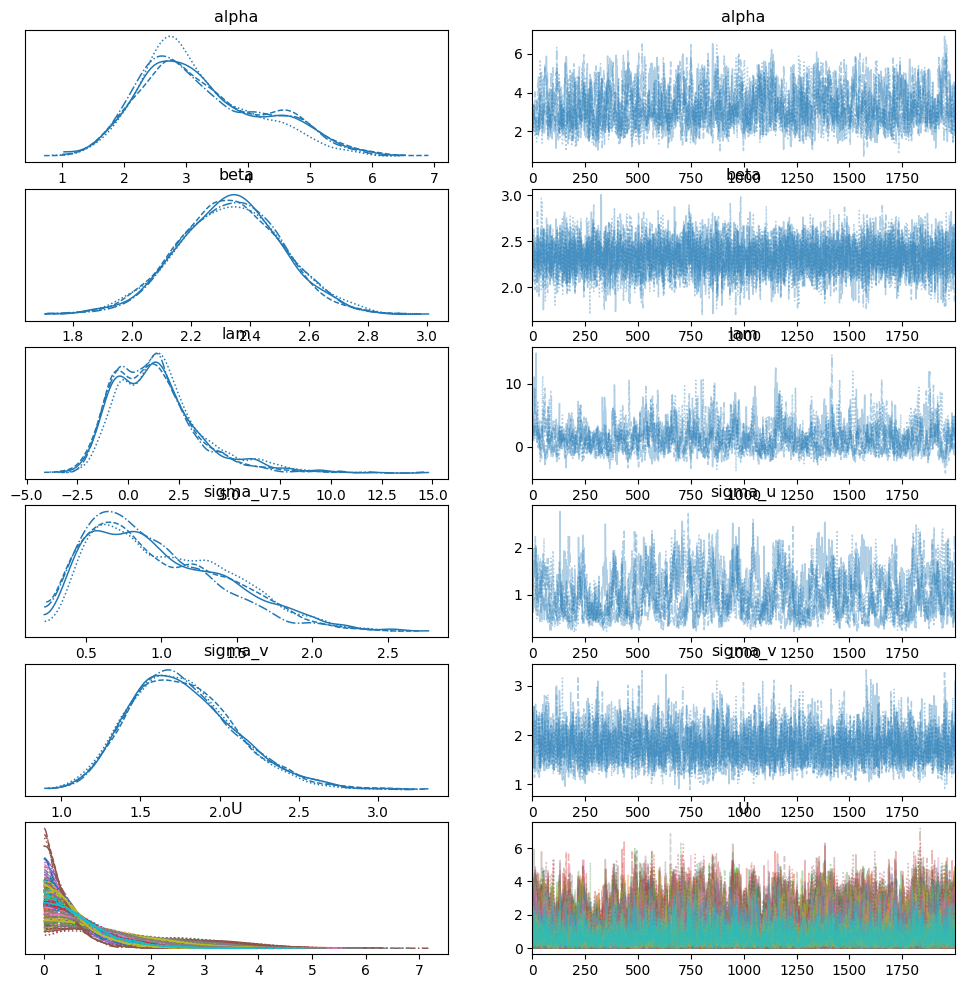

In [22]:
az.plot_trace(trace)
az.summary(trace, round_to=2)

# Simulation 2
$$ \lambda = -1 $$

## n = 50

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.46  0.55    3.41     5.46       0.01     0.00   4919.13   8817.55   
beta     2.29  0.17    1.96     2.61       0.00     0.00  22869.26  15688.55   
sigma_u  0.84  0.36    0.31     1.53       0.01     0.01   1807.35   3643.71   
sigma_v  1.73  0.33    1.13     2.33       0.00     0.00   7006.11   7578.74   
lam     -1.20  0.65   -2.27    -0.00       0.01     0.00   9096.84   8067.18   
U[0]     0.58  0.49    0.00     1.49       0.01     0.00   6289.70   6533.38   
U[1]     0.93  0.77    0.00     2.36       0.01     0.01   3209.54   6904.46   
U[2]     1.00  0.82    0.00     2.51       0.01     0.01   3445.80   6331.83   
U[3]     1.17  0.95    0.00     2.97       0.02     0.01   2675.69   5708.13   
U[4]     0.33  0.30    0.00     0.87       0.00     0.00  13659.97   9481.78   
U[5]     0.60  0.50    0.00     1.50       0.01     0.01   6497.34   7863.05   
U[6]     0.41  0.36    0.00     1.08       0.00     0.00   9702.53   7829.71   
U[7]     0.82  0.68    0.00     2.07       0.01     0.01   3936.91   7784.59   
U[8]     0.52  0.45    0.00     1.34       0.00     0.00   6592.11   7143.35   
U[9]     0.72  0.60    0.00     1.83       0.01     0.01   4597.31   7514.11   
U[10]    0.54  0.46    0.00     1.40       0.01     0.00   7094.90   8819.07   
U[11]    0.71  0.59    0.00     1.80       0.01     0.01   5250.53   8188.38   
U[12]    0.63  0.52    0.00     1.59       0.01     0.01   5680.54   7591.94   
U[13]    0.53  0.44    0.00     1.36       0.00     0.00   7475.29   8536.57   
U[14]    0.61  0.52    0.00     1.56       0.01     0.01   6335.29   8539.77   
U[15]    0.66  0.55    0.00     1.66       0.01     0.01   5430.46   7441.55   
U[16]    0.95  0.78    0.00     2.38       0.01     0.01   3710.49   7351.68   
U[17]    0.44  0.38    0.00     1.13       0.00     0.00   9871.13   8513.44   
U[18]    0.89  0.73    0.00     2.25       0.01     0.01   3609.22   6338.19   
U[19]    0.70  0.57    0.00     1.74       0.01     0.01   4381.42   7021.69   
U[20]    0.42  0.37    0.00     1.09       0.00     0.00  11060.60   9319.25   
U[21]    0.64  0.53    0.00     1.60       0.01     0.01   5821.65   7673.97   
U[22]    0.64  0.53    0.00     1.61       0.01     0.01   5752.29   7995.71   
U[23]    0.69  0.57    0.00     1.74       0.01     0.01   5130.68   8387.16   
U[24]    0.82  0.68    0.00     2.08       0.01     0.01   4326.20   7573.40   
U[25]    0.77  0.63    0.00     1.94       0.01     0.01   4367.24   7400.95   
U[26]    0.56  0.47    0.00     1.44       0.01     0.00   6917.10   8149.48   
U[27]    0.52  0.44    0.00     1.32       0.00     0.00   7271.35   7855.84   
U[28]    0.63  0.53    0.00     1.60       0.01     0.01   5763.51   8218.00   
U[29]    0.68  0.57    0.00     1.72       0.01     0.01   5335.71   8131.62   
U[30]    0.72  0.60    0.00     1.81       0.01     0.01   4574.02   8010.77   
U[31]    0.75  0.64    0.00     1.93       0.01     0.01   4749.68   7465.15   
U[32]    0.89  0.72    0.00     2.22       0.01     0.01   3716.69   7149.43   
U[33]    0.58  0.49    0.00     1.47       0.01     0.00   7272.86   8609.53   
U[34]    0.66  0.55    0.00     1.66       0.01     0.01   5237.06   7100.95   
U[35]    0.99  0.81    0.00     2.50       0.01     0.01   3482.70   6856.79   
U[36]    0.51  0.43    0.00     1.28       0.00     0.00   7643.11   8282.49   
U[37]    1.03  0.86    0.00     2.66       0.02     0.01   3017.39   6161.47   
U[38]    0.95  0.78    0.00     2.40       0.01     0.01   3431.43   6139.84   
U[39]    0.55  0.46    0.00     1.39       0.01     0.00   7083.02   7366.45   
U[40]    0.66  0.56    0.00     1.69       0.01     0.01   5679.86   8851.63   
U[41]    0.53  0.45    0.00     1.36       0.00     0.00   7908.11   9081.13   
U[42]    0.56  0.47    0.00     1.41       0.01     0.00   7137.81   7984.57   
U[43]    0.64  0.54    0.00     1.64       0.01     0.01   5154.71   6959.96   
U[44]    

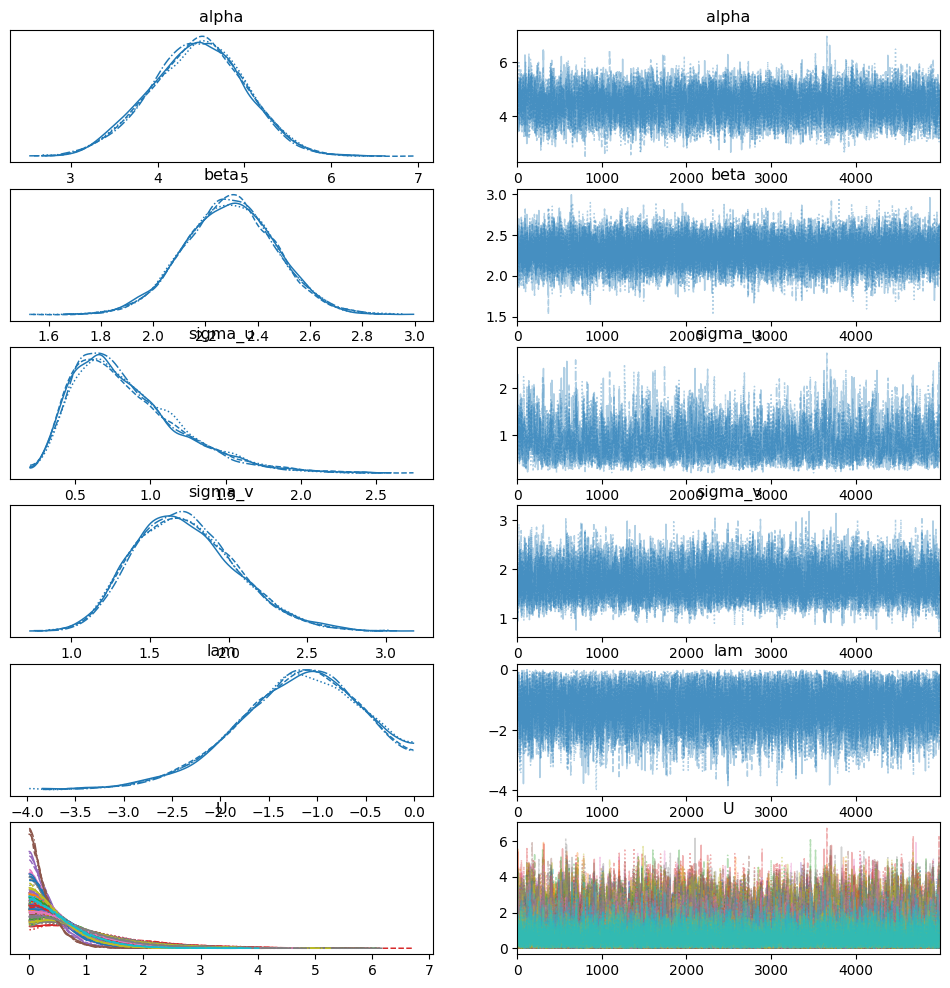

In [35]:
np.random.seed(123)

# Parameters 
n = 50
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -1

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.InverseGamma('sigma_u', 4, 3)
    sigma_v = pm.InverseGamma('sigma_v', 2.33, 3)
    lam = pm.TruncatedNormal('lam', mu=-2, sigma=1, lower=-4, upper=0)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(5000, tune=1000, target_accept=0.99, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace, round_to=2)

## n = 100

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 27 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    5.15  0.76    3.63     6.25       0.02     0.01   1784.34   3798.52   
beta     1.96  0.12    1.74     2.18       0.00     0.00   4943.16   6442.09   
lam     -1.36  2.84   -6.44     4.75       0.10     0.10    897.68    731.27   
sigma_u  1.03  0.43    0.33     1.80       0.02     0.01    371.13    850.81   
sigma_v  1.49  0.35    0.86     2.13       0.01     0.00    786.79   1357.00   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[95]    1.76  1.28    0.00     4.06       0.06     0.03    486.60   1157.07   
U[96]    1.17  0.86    0.00     2.72       0.03     0.02    696.64   1980.57   
U[97]    0.54  0.43    0.00     1.32       0.01     0.00   4013.79   7307.55   
U[98]    0.62  0.48    0.00     1.50       0.01     0.00   2588.93   7127.53   
U[99]    0.66  0.51    0.00     1.60       0.01     0.01   2333.58   7428.45   

         r_hat  
alpha     1.00  
beta      1.00  
lam       1.00  
sigma_u   1.01  
sigma_v   1.01  
...        ...  
U[95]     1.01  
U[96]     1.01  
U[97]     1.00  
U[98]     1.00  
U[99]     1.00  

[105 rows x 9 columns]

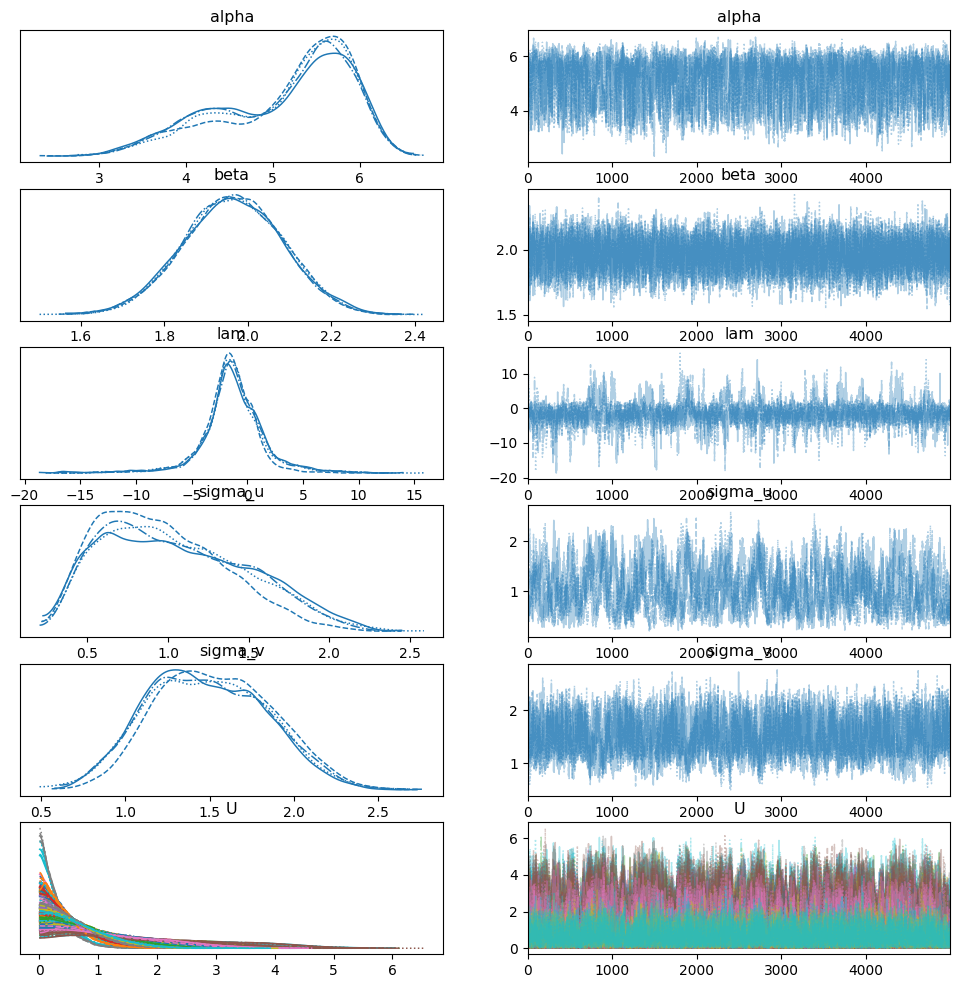

In [30]:
np.random.seed(123)

# Parameters 
n = 100
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -1

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.InverseGamma('sigma_u', 4, 3)
    sigma_v = pm.InverseGamma('sigma_v', 2, 3)
    lam = pm.Normal('lam', mu=-5, sigma=5)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(5000, tune=1000, target_accept=0.99, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace, round_to=2)

# Simulation 3

$$ \lambda = -1.5 $$

n = 50

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 17 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.44  0.52    3.42     5.38       0.01     0.00   5007.71   8797.06   
beta     2.26  0.16    1.95     2.56       0.00     0.00  22530.69  17188.43   
sigma_u  0.88  0.38    0.28     1.59       0.01     0.01   1904.49   3242.57   
sigma_v  1.67  0.33    1.09     2.29       0.00     0.00   5059.14   5459.87   
lam     -1.43  0.72   -2.67    -0.05       0.01     0.00   9962.02   9614.26   
U[0]     0.61  0.50    0.00     1.55       0.01     0.00   6694.63   9580.80   
U[1]     1.06  0.85    0.00     2.65       0.02     0.01   3173.17   5582.24   
U[2]     1.02  0.83    0.00     2.60       0.01     0.01   3387.98   5794.28   
U[3]     1.30  1.06    0.00     3.33       0.02     0.02   2742.84   4762.80   
U[4]     0.31  0.28    0.00     0.82       0.00     0.00  16162.77  11147.18   
U[5]     0.58  0.48    0.00     1.47       0.01     0.00   6888.67  10201.75   
U[6]     0.40  0.35    0.00     1.05       0.00     0.00  12757.41  10248.88   
U[7]     0.96  0.78    0.00     2.42       0.01     0.01   3185.47   6857.63   
U[8]     0.55  0.46    0.00     1.38       0.00     0.00   8042.69   9523.46   
U[9]     0.81  0.66    0.00     2.01       0.01     0.01   4323.07   7557.30   
U[10]    0.54  0.45    0.00     1.37       0.00     0.00   7836.84   9702.01   
U[11]    0.77  0.63    0.00     1.93       0.01     0.01   4814.64   9138.91   
U[12]    0.64  0.53    0.00     1.59       0.01     0.01   5797.17  10753.45   
U[13]    0.55  0.46    0.00     1.42       0.01     0.00   6890.61   9493.46   
U[14]    0.68  0.56    0.00     1.72       0.01     0.01   5785.44  10444.82   
U[15]    0.65  0.53    0.00     1.63       0.01     0.01   5478.47   9920.15   
U[16]    0.97  0.79    0.00     2.46       0.01     0.01   3538.20   6570.02   
U[17]    0.43  0.37    0.00     1.11       0.00     0.00  11086.89   9411.29   
U[18]    1.02  0.83    0.00     2.58       0.02     0.01   3018.71   5957.32   
U[19]    0.79  0.64    0.00     1.98       0.01     0.01   4503.38   7972.57   
U[20]    0.41  0.35    0.00     1.05       0.00     0.00  11841.19  10212.47   
U[21]    0.65  0.54    0.00     1.64       0.01     0.01   6000.75   9813.08   
U[22]    0.63  0.52    0.00     1.58       0.01     0.00   5545.90   9156.72   
U[23]    0.73  0.60    0.00     1.83       0.01     0.01   4838.20   9552.66   
U[24]    0.95  0.77    0.00     2.39       0.01     0.01   3314.73   6277.34   
U[25]    0.76  0.62    0.00     1.90       0.01     0.01   4611.17   8623.47   
U[26]    0.59  0.48    0.00     1.45       0.01     0.00   7429.86  10318.52   
U[27]    0.51  0.43    0.00     1.29       0.00     0.00   7621.42   7942.75   
U[28]    0.63  0.52    0.00     1.58       0.01     0.01   6397.20  10074.59   
U[29]    0.72  0.58    0.00     1.79       0.01     0.01   5453.75   9645.54   
U[30]    0.77  0.63    0.00     1.94       0.01     0.01   4837.16   8361.48   
U[31]    0.78  0.65    0.00     1.97       0.01     0.01   4605.43   8198.57   
U[32]    0.92  0.74    0.00     2.29       0.01     0.01   3874.59   7417.74   
U[33]    0.57  0.48    0.00     1.43       0.01     0.00   6900.86   9349.52   
U[34]    0.67  0.55    0.00     1.69       0.01     0.01   5936.45   9871.38   
U[35]    0.97  0.78    0.00     2.43       0.01     0.01   3345.84   6546.32   
U[36]    0.52  0.43    0.00     1.30       0.00     0.00   8740.55   9797.67   
U[37]    1.15  0.94    0.00     2.92       0.02     0.01   3075.61   5163.54   
U[38]    1.06  0.86    0.00     2.69       0.02     0.01   3133.96   6247.94   
U[39]    0.53  0.43    0.00     1.31       0.00     0.00   8026.31  10202.06   
U[40]    0.70  0.57    0.00     1.76       0.01     0.01   5155.10   8171.33   
U[41]    0.52  0.44    0.00     1.33       0.00     0.00   8640.36   9992.59   
U[42]    0.60  0.49    0.00     1.50       0.01     0.00   7166.40  10166.40   
U[43]    0.66  0.54    0.00     1.65       0.01     0.01   5355.46   8805.68   
U[44]    

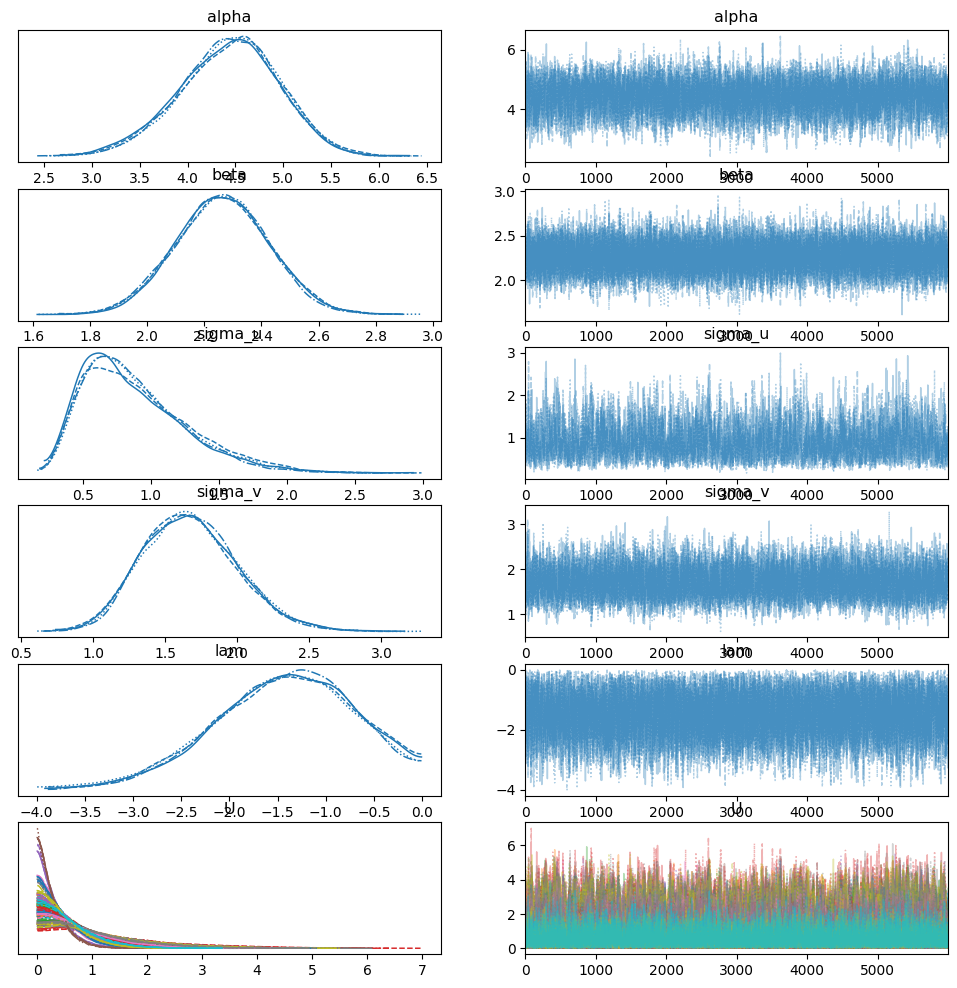

In [38]:
np.random.seed(123)

# Parameters 
n = 50
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -1.5

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.InverseGamma('sigma_u', 4, 3)
    sigma_v = pm.InverseGamma('sigma_v', 2.33, 3)
    lam = pm.TruncatedNormal('lam', mu=-2, sigma=1, lower=-4, upper=0)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace, round_to=2)

n = 100

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    5.23  0.33    4.60     5.81       0.01     0.00   1747.30   5739.10   
beta     1.98  0.10    1.79     2.17       0.00     0.00  11032.10  14926.23   
sigma_u  0.94  0.38    0.33     1.64       0.02     0.01    433.58   1097.09   
sigma_v  1.44  0.27    0.90     1.92       0.01     0.00    813.02   1236.46   
lam     -1.91  0.78   -3.41    -0.45       0.01     0.01   5920.04   6309.94   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[95]    1.54  1.13    0.00     3.62       0.05     0.02    621.05   1768.39   
U[96]    1.10  0.80    0.00     2.56       0.03     0.01    854.30   2939.71   
U[97]    0.47  0.37    0.00     1.15       0.01     0.00   4558.92   7412.38   
U[98]    0.52  0.41    0.00     1.27       0.01     0.00   3989.10   6659.27   
U[99]    0.60  0.47    0.00     1.45       0.01     0.00   2975.58   6542.54   

         r_hat  
alpha     1.00  
beta      1.00  
sigma_u   1.01  
sigma_v   1.01  
lam       1.00  
...        ...  
U[95]     1.01  
U[96]     1.01  
U[97]     1.00  
U[98]     1.00  
U[99]     1.00  

[105 rows x 9 columns]

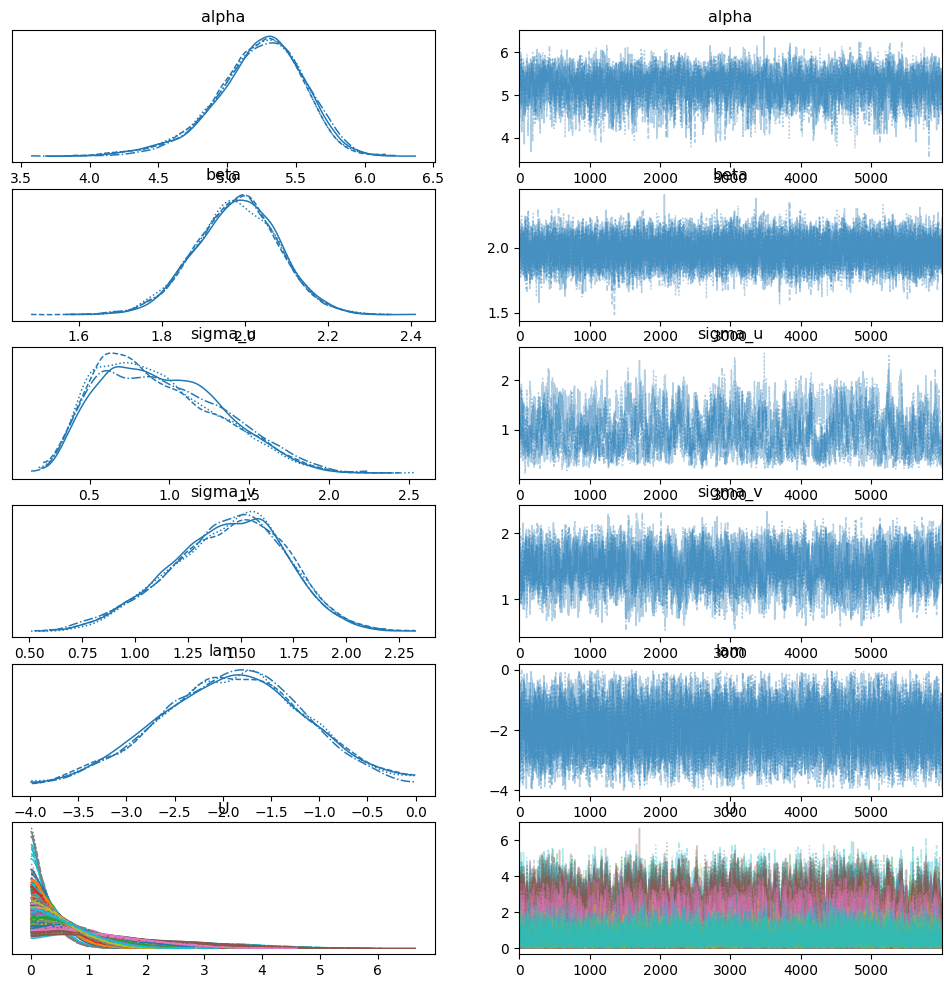

In [39]:
np.random.seed(123)

# Parameters 
n = 100
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -1.5

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.InverseGamma('sigma_u', 4, 3)
    sigma_v = pm.InverseGamma('sigma_v', 2.33, 3)
    lam = pm.TruncatedNormal('lam', mu=-2, sigma=1, lower=-4, upper=0)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace, round_to=2)

n = 200

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 41 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.91  0.26    4.41     5.41       0.01     0.00   2325.75   5553.97   
beta     2.03  0.08    1.88     2.18       0.00     0.00  19380.11  17135.85   
sigma_u  0.87  0.34    0.34     1.50       0.02     0.01    402.16   1066.79   
sigma_v  1.52  0.25    1.00     1.93       0.01     0.00    622.47   1413.19   
lam     -1.77  0.60   -2.94    -0.58       0.01     0.01   2851.66   2728.70   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[195]   0.60  0.47    0.00     1.45       0.01     0.01   2733.50   6824.58   
U[196]   0.69  0.53    0.00     1.67       0.01     0.01   1821.16   5918.36   
U[197]   0.49  0.39    0.00     1.21       0.01     0.00   4073.10   9158.10   
U[198]   0.68  0.52    0.00     1.63       0.01     0.01   1982.46   6922.91   
U[199]   0.69  0.53    0.00     1.65       0.01     0.01   1796.06   5968.15   

         r_hat  
alpha     1.00  
beta      1.00  
sigma_u   1.01  
sigma_v   1.01  
lam       1.00  
...        ...  
U[195]    1.00  
U[196]    1.00  
U[197]    1.00  
U[198]    1.00  
U[199]    1.00  

[205 rows x 9 columns]

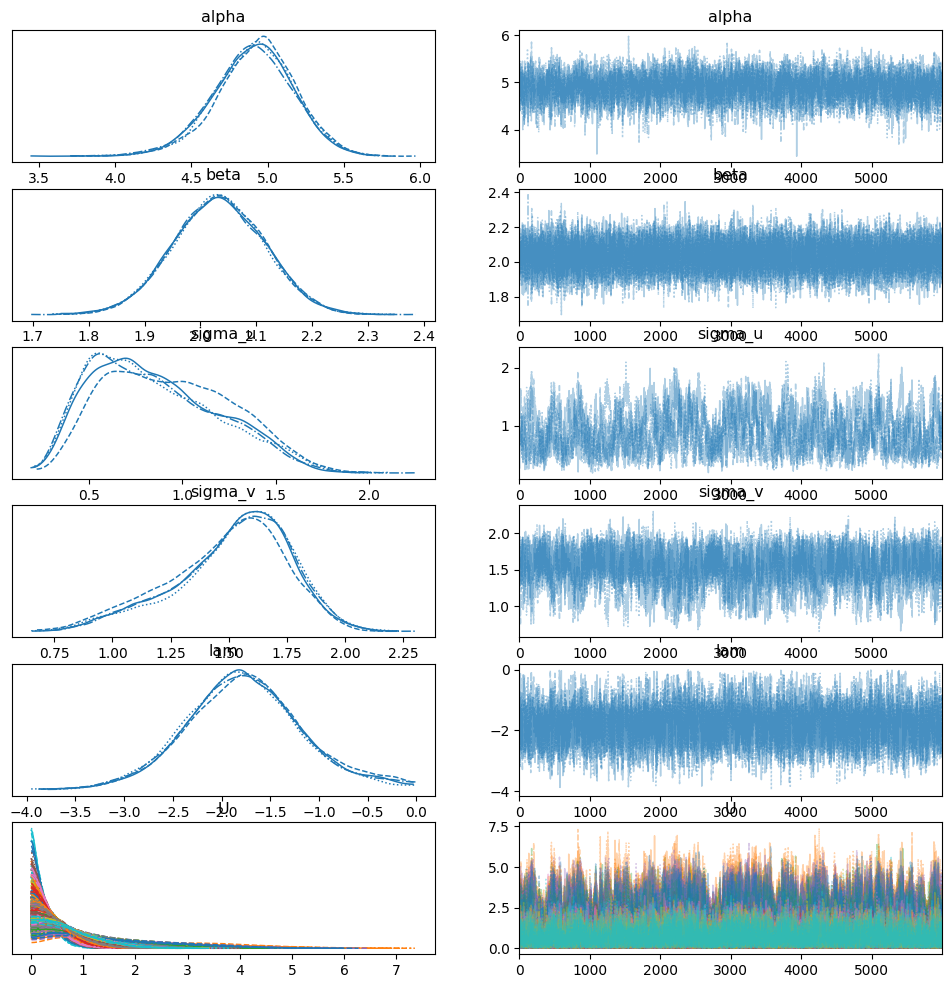

In [40]:
np.random.seed(123)

# Parameters 
n = 200
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -1.5

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.InverseGamma('sigma_u', 4, 3)
    sigma_v = pm.InverseGamma('sigma_v', 2.33, 3)
    lam = pm.TruncatedNormal('lam', mu=-2, sigma=1, lower=-4, upper=0)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace, round_to=2)

n = 500

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 69 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.75  0.28    4.20     5.25       0.01     0.00   1715.35   5266.20   
beta     1.91  0.05    1.82     2.01       0.00     0.00  32590.09  17784.85   
sigma_u  0.75  0.24    0.32     1.20       0.01     0.01    299.78    814.61   
sigma_v  1.32  0.16    1.02     1.62       0.01     0.00    860.90   1757.26   
lam     -1.02  0.43   -1.79    -0.15       0.01     0.00   6077.75   9585.05   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[495]   0.38  0.31    0.00     0.95       0.00     0.00   7689.79  11170.96   
U[496]   0.61  0.47    0.00     1.46       0.01     0.01   1996.01   6515.19   
U[497]   0.44  0.35    0.00     1.07       0.01     0.00   4387.45  11378.52   
U[498]   0.70  0.53    0.00     1.66       0.01     0.01   1481.50   5038.68   
U[499]   0.88  0.64    0.00     2.03       0.02     0.01   1064.64   3496.74   

         r_hat  
alpha     1.00  
beta      1.00  
sigma_u   1.01  
sigma_v   1.00  
lam       1.00  
...        ...  
U[495]    1.00  
U[496]    1.00  
U[497]    1.00  
U[498]    1.00  
U[499]    1.00  

[505 rows x 9 columns]

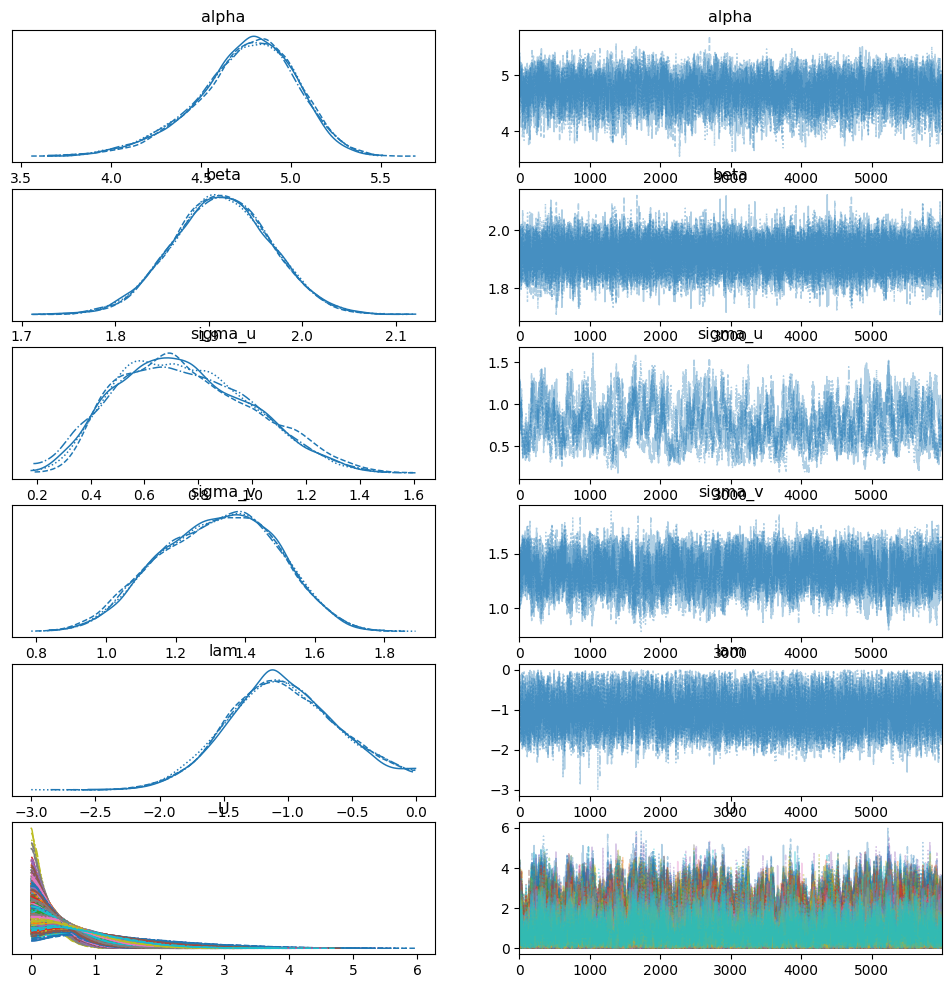

In [41]:
np.random.seed(123)

# Parameters 
n = 500
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -1.5

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.InverseGamma('sigma_u', 4, 3)
    sigma_v = pm.InverseGamma('sigma_v', 2.33, 3)
    lam = pm.TruncatedNormal('lam', mu=-2, sigma=1, lower=-4, upper=0)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace, round_to=2)

# Simulation 4

$$ \lambda = -2 $$

n = 50

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 19 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    3.27  1.04    1.60     5.22       0.02     0.01   2413.85   5204.66   
beta     2.30  0.17    1.98     2.63       0.00     0.00  10324.64  12762.43   
lam      0.85  2.11   -2.65     4.92       0.06     0.04   1381.84   2537.44   
sigma_u  0.96  0.42    0.31     1.76       0.01     0.01    964.27   2522.09   
sigma_v  1.67  0.34    1.07     2.31       0.00     0.00   4384.19   5152.24   
U[0]     0.62  0.53    0.00     1.58       0.01     0.01   4271.70   5498.11   
U[1]     1.17  0.91    0.00     2.82       0.03     0.01   1353.50   3832.93   
U[2]     1.28  0.97    0.00     3.05       0.03     0.01   1360.15   4155.46   
U[3]     1.62  1.21    0.00     3.83       0.04     0.02   1176.98   2820.49   
U[4]     0.39  0.36    0.00     1.04       0.00     0.00   8138.34   6747.72   
U[5]     0.62  0.53    0.00     1.58       0.01     0.01   3920.50   5486.87   
U[6]     0.46  0.41    0.00     1.21       0.00     0.00   6661.88   6196.66   
U[7]     0.96  0.76    0.00     2.33       0.02     0.01   1878.38   5535.47   
U[8]     0.56  0.48    0.00     1.44       0.01     0.00   4987.09   5177.31   
U[9]     0.80  0.64    0.00     1.95       0.01     0.01   2421.61   5800.31   
U[10]    0.58  0.50    0.00     1.49       0.01     0.01   5155.20   7025.03   
U[11]    0.77  0.64    0.00     1.95       0.01     0.01   2582.51   6813.66   
U[12]    0.66  0.56    0.00     1.66       0.01     0.01   3800.99   5231.79   
U[13]    0.56  0.49    0.00     1.45       0.01     0.01   5211.16   5896.14   
U[14]    0.66  0.55    0.00     1.66       0.01     0.01   3368.47   6337.51   
U[15]    0.70  0.58    0.00     1.77       0.01     0.01   2948.97   6163.11   
U[16]    1.19  0.91    0.00     2.87       0.02     0.01   1489.25   3944.22   
U[17]    0.49  0.43    0.00     1.27       0.00     0.00   7298.52   7210.37   
U[18]    1.09  0.84    0.00     2.61       0.02     0.01   1498.91   4217.33   
U[19]    0.74  0.61    0.00     1.85       0.01     0.01   3075.43   5848.57   
U[20]    0.46  0.41    0.00     1.21       0.00     0.00   7292.48   8392.78   
U[21]    0.68  0.57    0.00     1.72       0.01     0.01   3483.09   6281.06   
U[22]    0.68  0.56    0.00     1.71       0.01     0.01   3458.70   6226.93   
U[23]    0.74  0.62    0.00     1.87       0.01     0.01   2782.14   6974.76   
U[24]    0.96  0.76    0.00     2.36       0.02     0.01   1851.11   5255.68   
U[25]    0.87  0.70    0.00     2.17       0.02     0.01   1894.30   5822.08   
U[26]    0.60  0.50    0.00     1.53       0.01     0.01   4469.72   7133.90   
U[27]    0.55  0.49    0.00     1.45       0.01     0.01   5350.80   6989.44   
U[28]    0.66  0.55    0.00     1.67       0.01     0.01   3756.30   6476.37   
U[29]    0.74  0.61    0.00     1.85       0.01     0.01   2884.48   6568.72   
U[30]    0.78  0.64    0.00     1.96       0.01     0.01   2204.70   4865.75   
U[31]    0.84  0.69    0.00     2.13       0.01     0.01   2252.08   5330.88   
U[32]    1.08  0.84    0.00     2.61       0.02     0.01   1584.27   4292.51   
U[33]    0.61  0.52    0.00     1.55       0.01     0.01   4490.25   6192.64   
U[34]    0.71  0.58    0.00     1.79       0.01     0.01   2983.37   6154.89   
U[35]    1.28  0.97    0.00     3.04       0.03     0.01   1372.86   3695.71   
U[36]    0.54  0.47    0.00     1.40       0.01     0.01   5930.79   7057.63   
U[37]    1.37  1.03    0.00     3.22       0.03     0.01   1258.27   3759.60   
U[38]    1.19  0.91    0.00     2.86       0.03     0.01   1358.68   3636.62   
U[39]    0.57  0.49    0.00     1.47       0.01     0.01   5489.95   6405.14   
U[40]    0.71  0.59    0.00     1.80       0.01     0.01   3361.60   6148.47   
U[41]    0.56  0.49    0.00     1.46       0.01     0.01   4592.01   6759.58   
U[42]    0.59  0.51    0.00     1.51       0.01     0.01   5428.88   8201.76   
U[43]    0.68  0.57    0.00     1.71       0.01     0.01   3266.77   6126.69   
U[44]    

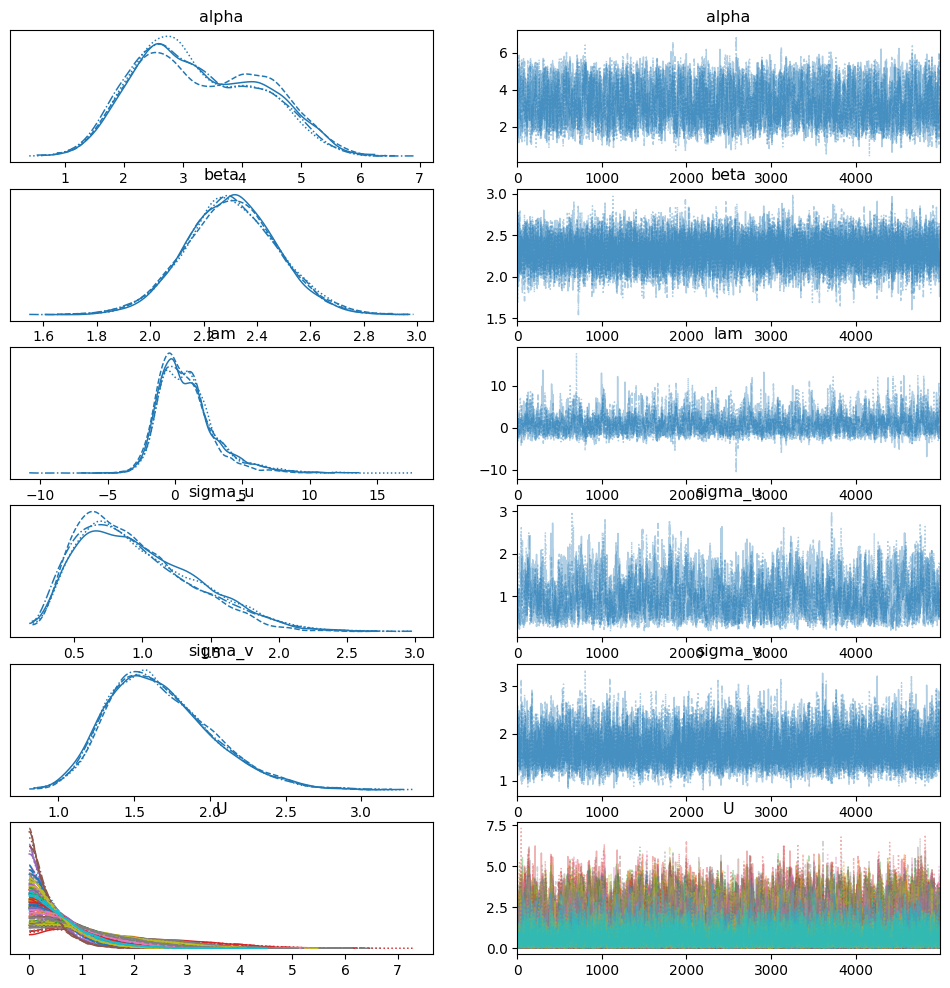

In [28]:
np.random.seed(123)

# Parameters 
n = 50
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -1.5

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.InverseGamma('sigma_u', 4, 3)
    sigma_v = pm.InverseGamma('sigma_v', 2.33, 3)
    lam = pm.TruncatedNormal('lam', mu=-2, sigma=1, lower=-4, upper=0)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace, round_to=2)

n = 100

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 30 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    5.08  0.30    4.50     5.61       0.01     0.00   1986.74   7717.17   
beta     1.99  0.09    1.81     2.16       0.00     0.00  15434.69  16459.95   
sigma_u  0.91  0.36    0.33     1.58       0.02     0.01    587.05   1404.64   
sigma_v  1.41  0.27    0.89     1.89       0.01     0.00   1012.23   1530.31   
lam     -2.03  0.79   -3.55    -0.54       0.01     0.01   8169.49   8030.89   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[95]    1.48  1.10    0.00     3.55       0.04     0.02    845.46   2404.33   
U[96]    1.08  0.79    0.00     2.52       0.02     0.01   1228.08   3803.55   
U[97]    0.44  0.35    0.00     1.08       0.00     0.00   5975.15   8618.80   
U[98]    0.47  0.37    0.00     1.13       0.01     0.00   4986.14   8740.38   
U[99]    0.59  0.45    0.00     1.40       0.01     0.00   3408.06   6347.11   

         r_hat  
alpha     1.01  
beta      1.00  
sigma_u   1.02  
sigma_v   1.01  
lam       1.00  
...        ...  
U[95]     1.01  
U[96]     1.01  
U[97]     1.00  
U[98]     1.00  
U[99]     1.00  

[105 rows x 9 columns]

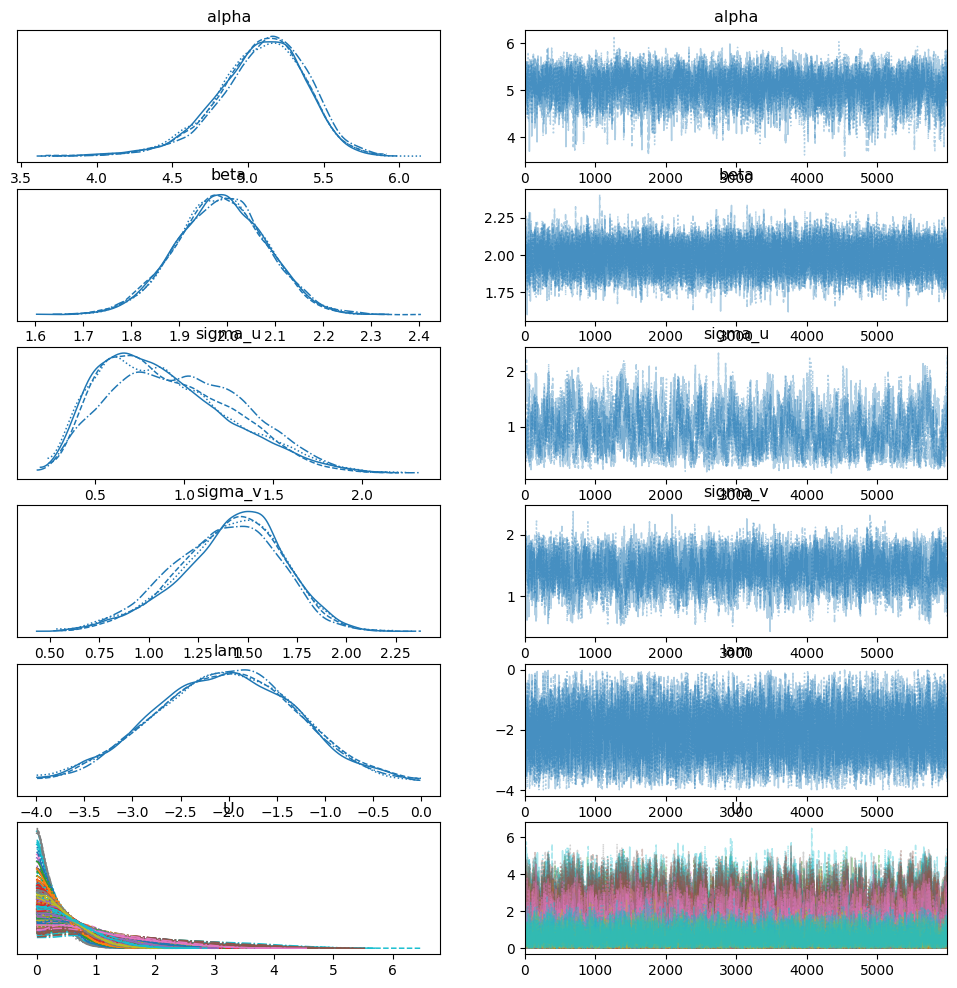

In [42]:
np.random.seed(123)

# Parameters 
n = 100
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -2

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.InverseGamma('sigma_u', 4, 3)
    sigma_v = pm.InverseGamma('sigma_v', 2.33, 3)
    lam = pm.TruncatedNormal('lam', mu=-2, sigma=1, lower=-4, upper=0)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace, round_to=2)

n = 200

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 43 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.81  0.24    4.37     5.25       0.01     0.00   1482.44   5104.81   
beta     2.02  0.08    1.89     2.18       0.00     0.00  19696.94  17583.06   
sigma_u  0.84  0.33    0.30     1.44       0.02     0.01    340.57    741.47   
sigma_v  1.46  0.24    0.97     1.86       0.01     0.01    560.69    994.55   
lam     -1.94  0.62   -3.20    -0.80       0.01     0.01   2688.57   2200.22   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[195]   0.53  0.42    0.00     1.28       0.01     0.00   2692.63   7027.30   
U[196]   0.63  0.48    0.00     1.52       0.01     0.01   1626.89   4508.87   
U[197]   0.51  0.40    0.00     1.24       0.01     0.00   2840.46   8225.21   
U[198]   0.64  0.49    0.00     1.53       0.01     0.01   1575.04   5455.39   
U[199]   0.67  0.51    0.00     1.62       0.01     0.01   1787.85   4348.59   

         r_hat  
alpha      1.0  
beta       1.0  
sigma_u    1.0  
sigma_v    1.0  
lam        1.0  
...        ...  
U[195]     1.0  
U[196]     1.0  
U[197]     1.0  
U[198]     1.0  
U[199]     1.0  

[205 rows x 9 columns]

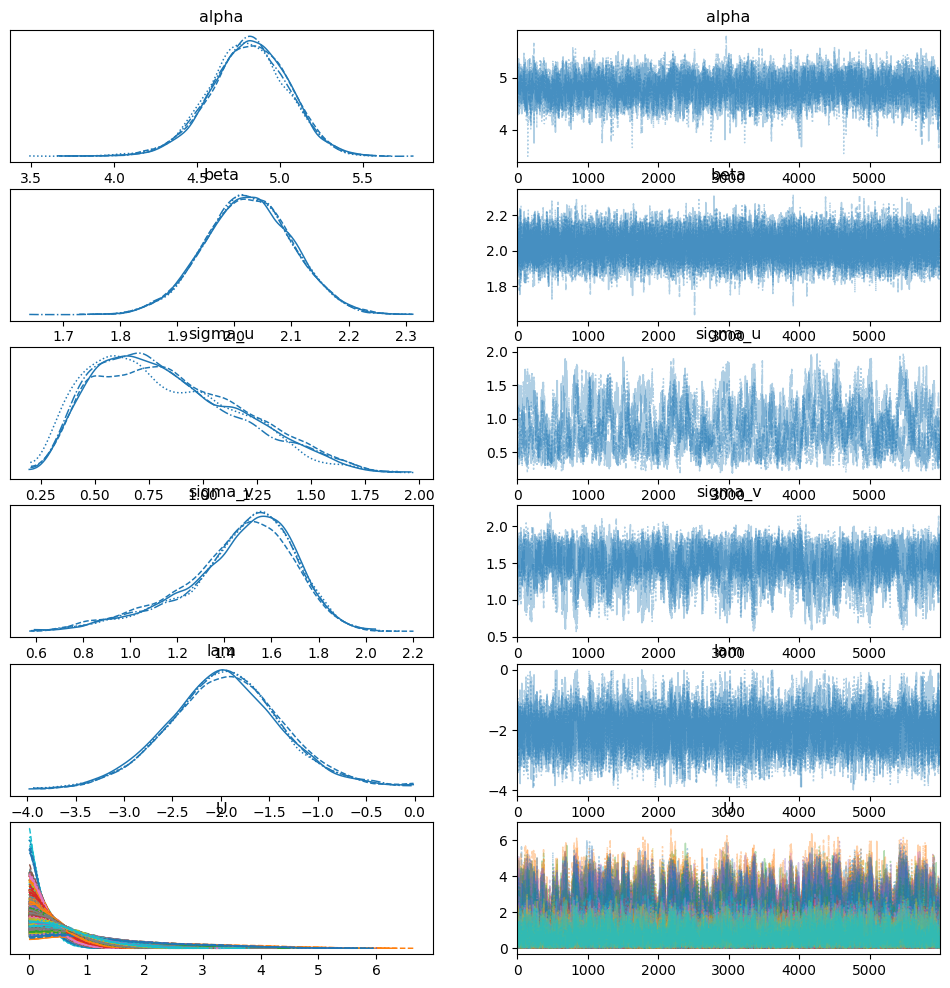

In [43]:
np.random.seed(123)

# Parameters 
n = 200
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -2

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.InverseGamma('sigma_u', 4, 3)
    sigma_v = pm.InverseGamma('sigma_v', 2.33, 3)
    lam = pm.TruncatedNormal('lam', mu=-2, sigma=1, lower=-4, upper=0)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace, round_to=2)

n = 500

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 73 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.80  0.22    4.40     5.22       0.01     0.00   1554.25   3993.65   
beta     1.92  0.05    1.83     2.02       0.00     0.00  33034.34  18832.86   
sigma_u  0.79  0.26    0.34     1.26       0.01     0.01    310.36    777.67   
sigma_v  1.32  0.18    0.95     1.62       0.01     0.00    562.82   1133.76   
lam     -1.42  0.48   -2.32    -0.45       0.01     0.01   3210.30   3920.35   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[495]   0.37  0.30    0.00     0.91       0.00     0.00   7786.42  11335.49   
U[496]   0.70  0.52    0.00     1.64       0.01     0.01   1642.03   4942.39   
U[497]   0.42  0.34    0.00     1.04       0.00     0.00   4891.74  10514.23   
U[498]   0.70  0.51    0.00     1.64       0.01     0.01   1498.82   3777.11   
U[499]   0.99  0.70    0.00     2.26       0.03     0.01    736.77   2387.64   

         r_hat  
alpha     1.00  
beta      1.00  
sigma_u   1.01  
sigma_v   1.00  
lam       1.00  
...        ...  
U[495]    1.00  
U[496]    1.00  
U[497]    1.00  
U[498]    1.00  
U[499]    1.00  

[505 rows x 9 columns]

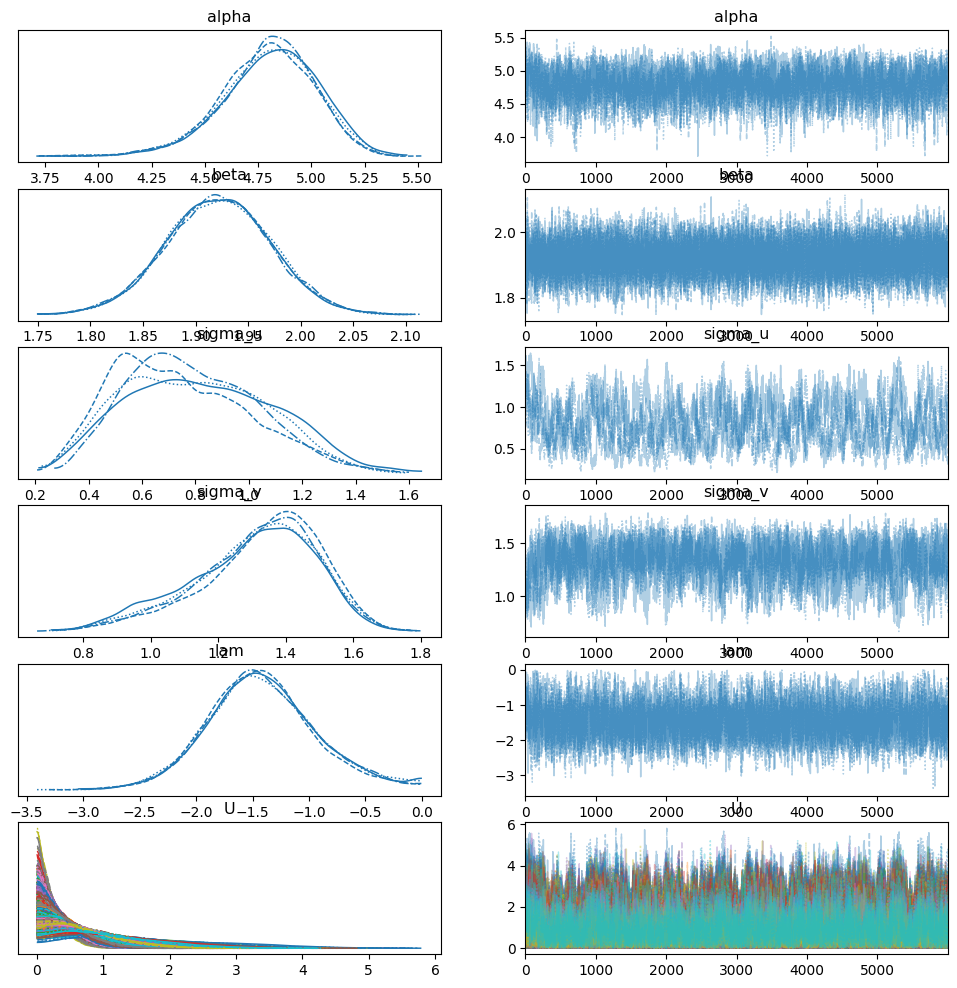

In [44]:
np.random.seed(123)

# Parameters 
n = 500
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -2

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.InverseGamma('sigma_u', 4, 3)
    sigma_v = pm.InverseGamma('sigma_v', 2.33, 3)
    lam = pm.TruncatedNormal('lam', mu=-2, sigma=1, lower=-4, upper=0)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace, round_to=2)

# Simulation 5

$$ \lambda = -5 $$

n = 50

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 25 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.47  0.37    3.79     5.17       0.01     0.00   2542.99   7522.98   
beta     2.18  0.14    1.93     2.44       0.00     0.00  13473.27  15045.05   
sigma_u  0.96  0.44    0.30     1.77       0.02     0.01    701.00   1605.88   
sigma_v  1.46  0.34    0.76     2.05       0.01     0.01    894.47   1324.74   
lam     -2.16  0.82   -3.71    -0.63       0.01     0.01   7325.67   7482.72   
U[0]     0.71  0.54    0.00     1.68       0.01     0.01   2219.17   7223.87   
U[1]     1.35  1.04    0.00     3.29       0.04     0.02    882.04   2482.04   
U[2]     1.07  0.81    0.00     2.57       0.03     0.01    959.06   3153.95   
U[3]     1.56  1.23    0.00     3.88       0.05     0.02    868.39   2246.19   
U[4]     0.24  0.23    0.00     0.66       0.00     0.00  14195.65   9588.34   
U[5]     0.54  0.42    0.00     1.30       0.01     0.00   4339.96   6429.58   
U[6]     0.37  0.32    0.00     0.96       0.00     0.00   7864.84   8594.91   
U[7]     1.36  1.05    0.00     3.35       0.04     0.02    910.01   2086.97   
U[8]     0.68  0.52    0.00     1.63       0.01     0.00   2527.09   5868.61   
U[9]     1.07  0.80    0.00     2.55       0.03     0.01   1158.83   3367.26   
U[10]    0.52  0.41    0.00     1.26       0.01     0.00   4457.59   6350.42   
U[11]    0.90  0.68    0.00     2.15       0.02     0.01   1603.29   4677.89   
U[12]    0.63  0.49    0.00     1.52       0.01     0.00   3474.84   7866.20   
U[13]    0.64  0.49    0.00     1.53       0.01     0.00   3108.07   7706.22   
U[14]    0.89  0.67    0.00     2.13       0.02     0.01   1541.69   4453.25   
U[15]    0.55  0.43    0.00     1.32       0.01     0.00   3795.42   6921.16   
U[16]    0.96  0.73    0.00     2.31       0.02     0.01   1466.33   4423.70   
U[17]    0.41  0.34    0.00     1.03       0.00     0.00  10550.01  10347.29   
U[18]    1.36  1.04    0.00     3.29       0.04     0.02   1006.89   2579.32   
U[19]    1.04  0.79    0.00     2.51       0.03     0.01   1091.59   4033.98   
U[20]    0.39  0.32    0.00     0.98       0.00     0.00   9455.20   8277.78   
U[21]    0.67  0.51    0.00     1.61       0.01     0.01   2622.06   6490.29   
U[22]    0.56  0.43    0.00     1.34       0.01     0.00   3224.22   7574.93   
U[23]    0.82  0.61    0.00     1.95       0.02     0.01   1657.17   5576.47   
U[24]    1.33  1.04    0.00     3.28       0.04     0.02    938.05   2602.83   
U[25]    0.65  0.49    0.00     1.55       0.01     0.00   2419.96   5959.97   
U[26]    0.62  0.47    0.00     1.48       0.01     0.00   2983.68   7145.69   
U[27]    0.42  0.34    0.00     1.02       0.00     0.00   7362.51   9289.55   
U[28]    0.61  0.47    0.00     1.46       0.01     0.00   2721.45   6628.68   
U[29]    0.80  0.61    0.00     1.92       0.01     0.01   1977.50   5942.30   
U[30]    0.91  0.69    0.00     2.19       0.02     0.01   1558.04   4660.16   
U[31]    0.79  0.62    0.00     1.93       0.02     0.01   1717.51   4849.47   
U[32]    0.96  0.74    0.00     2.32       0.02     0.01   1400.36   3508.06   
U[33]    0.52  0.40    0.00     1.26       0.01     0.00   4275.02   6648.90   
U[34]    0.65  0.49    0.00     1.54       0.01     0.00   2678.19   7246.84   
U[35]    0.79  0.59    0.00     1.87       0.01     0.01   1920.28   5513.66   
U[36]    0.54  0.42    0.00     1.32       0.01     0.00   3508.36   7605.91   
U[37]    1.37  1.06    0.00     3.34       0.04     0.02    930.10   2598.26   
U[38]    1.37  1.07    0.00     3.35       0.04     0.02    987.94   2837.65   
U[39]    0.42  0.34    0.00     1.04       0.00     0.00   6574.04   7520.17   
U[40]    0.79  0.60    0.00     1.88       0.02     0.01   1665.98   5277.24   
U[41]    0.50  0.40    0.00     1.23       0.01     0.00   4695.28   8842.32   
U[42]    0.68  0.52    0.00     1.64       0.01     0.01   2506.85   5674.26   
U[43]    0.66  0.49    0.00     1.56       0.01     0.00   2628.57   8268.14   
U[44]    

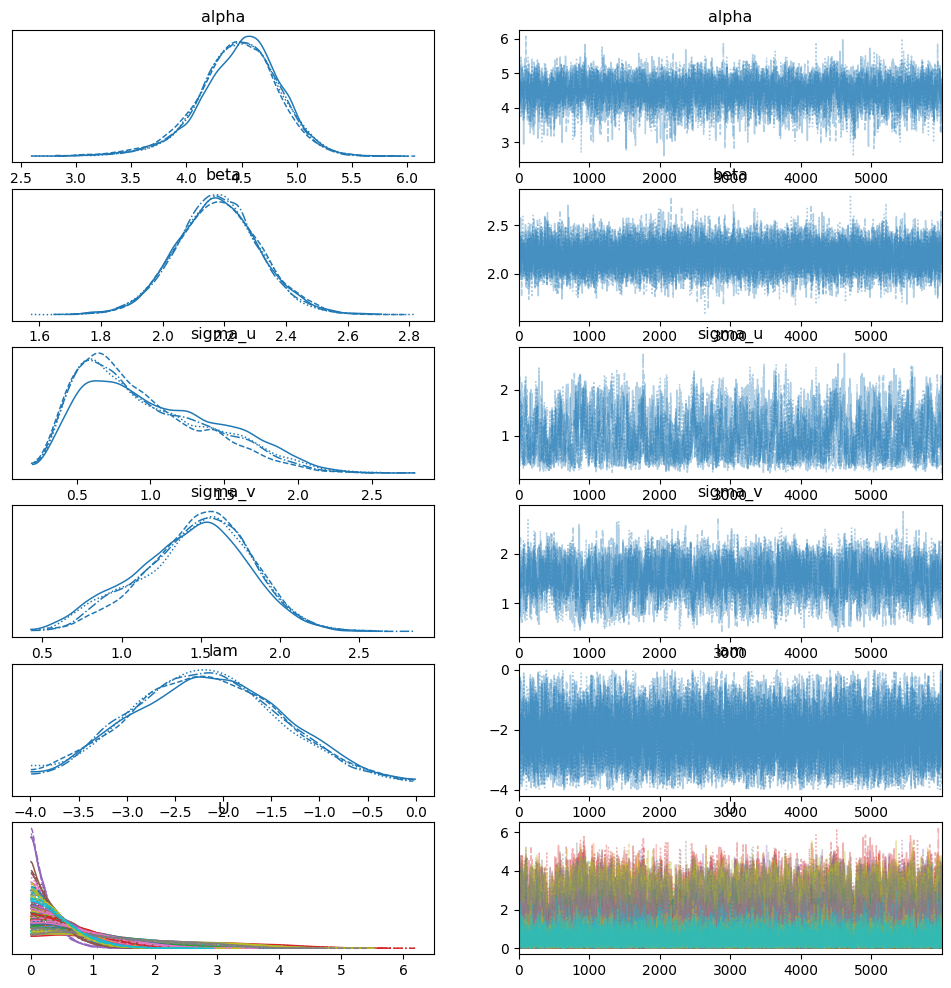

In [45]:
np.random.seed(123)

# Parameters 
n = 50
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -5

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.InverseGamma('sigma_u', 4, 3)
    sigma_v = pm.InverseGamma('sigma_v', 2.33, 3)
    lam = pm.TruncatedNormal('lam', mu=-2, sigma=1, lower=-4, upper=0)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace, round_to=2)

n = 100

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 30 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    5.10  0.30    4.52     5.64       0.01     0.00   1551.57   5493.25   
beta     1.99  0.09    1.81     2.16       0.00     0.00  11541.78  14873.14   
sigma_u  0.95  0.38    0.32     1.63       0.02     0.01    458.63   1335.92   
sigma_v  1.39  0.28    0.83     1.86       0.01     0.00    813.44   1489.01   
lam     -2.04  0.79   -3.52    -0.54       0.01     0.01   6234.86   6141.00   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[95]    1.58  1.14    0.00     3.65       0.05     0.02    672.15   2002.77   
U[96]    1.14  0.82    0.00     2.66       0.03     0.01    890.76   3744.27   
U[97]    0.45  0.35    0.00     1.09       0.00     0.00   5207.52   8837.66   
U[98]    0.48  0.37    0.00     1.16       0.01     0.00   4899.44   8006.84   
U[99]    0.60  0.45    0.00     1.42       0.01     0.00   2827.90   6535.95   

         r_hat  
alpha     1.00  
beta      1.00  
sigma_u   1.01  
sigma_v   1.00  
lam       1.00  
...        ...  
U[95]     1.01  
U[96]     1.00  
U[97]     1.00  
U[98]     1.00  
U[99]     1.00  

[105 rows x 9 columns]

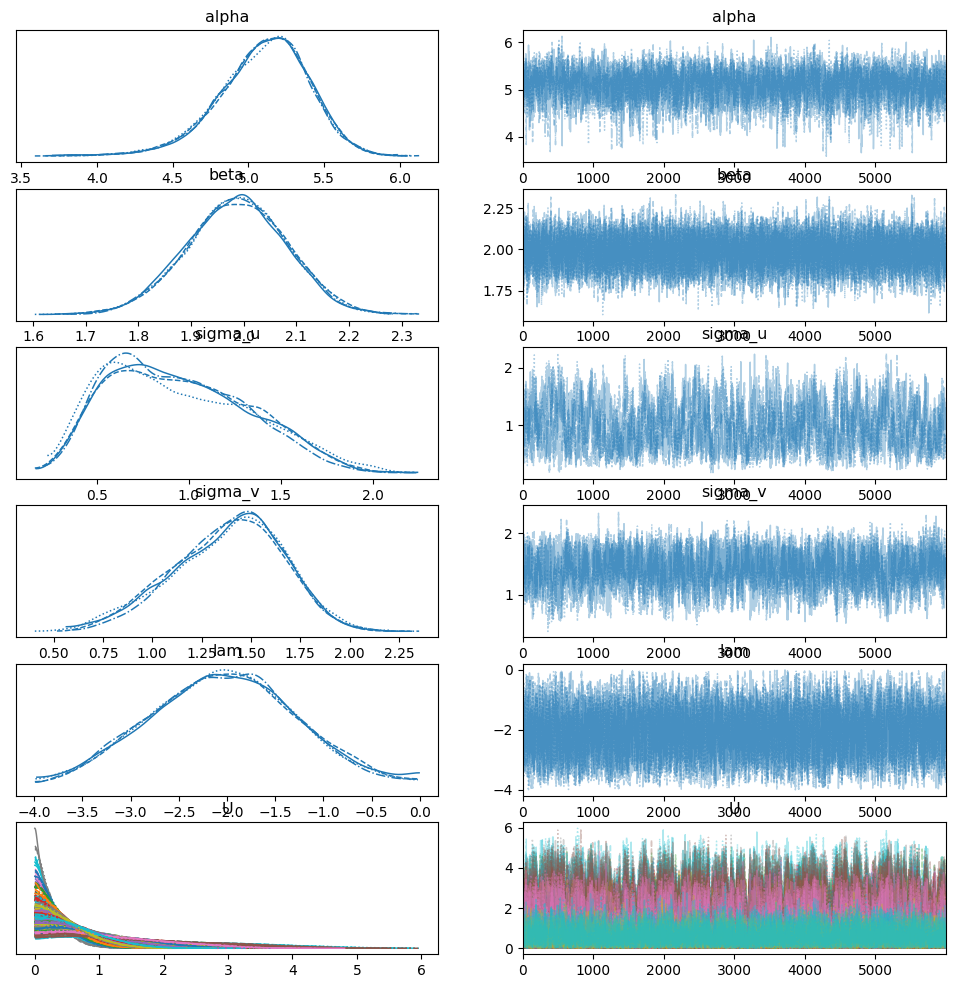

In [46]:
np.random.seed(123)

# Parameters 
n = 100
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -2

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.InverseGamma('sigma_u', 4, 3)
    sigma_v = pm.InverseGamma('sigma_v', 2.33, 3)
    lam = pm.TruncatedNormal('lam', mu=-2, sigma=1, lower=-4, upper=0)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace, round_to=2)

n = 200

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 43 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.82  0.24    4.40     5.29       0.01     0.00   1316.21   4149.31   
beta     2.02  0.08    1.88     2.17       0.00     0.00  17322.68  15314.52   
sigma_u  0.88  0.34    0.34     1.51       0.02     0.01    299.77   1039.38   
sigma_v  1.44  0.25    0.93     1.84       0.01     0.01    414.85   1136.49   
lam     -1.92  0.63   -3.17    -0.70       0.02     0.01   1707.16   2140.90   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[195]   0.55  0.43    0.00     1.33       0.01     0.01   2072.52   6031.00   
U[196]   0.66  0.50    0.00     1.55       0.01     0.01   1402.30   4741.06   
U[197]   0.54  0.41    0.00     1.29       0.01     0.00   2085.41   6382.68   
U[198]   0.66  0.50    0.00     1.58       0.01     0.01   1428.58   4602.67   
U[199]   0.71  0.53    0.00     1.67       0.02     0.01   1244.18   4224.02   

         r_hat  
alpha     1.00  
beta      1.00  
sigma_u   1.01  
sigma_v   1.01  
lam       1.00  
...        ...  
U[195]    1.00  
U[196]    1.00  
U[197]    1.00  
U[198]    1.00  
U[199]    1.00  

[205 rows x 9 columns]

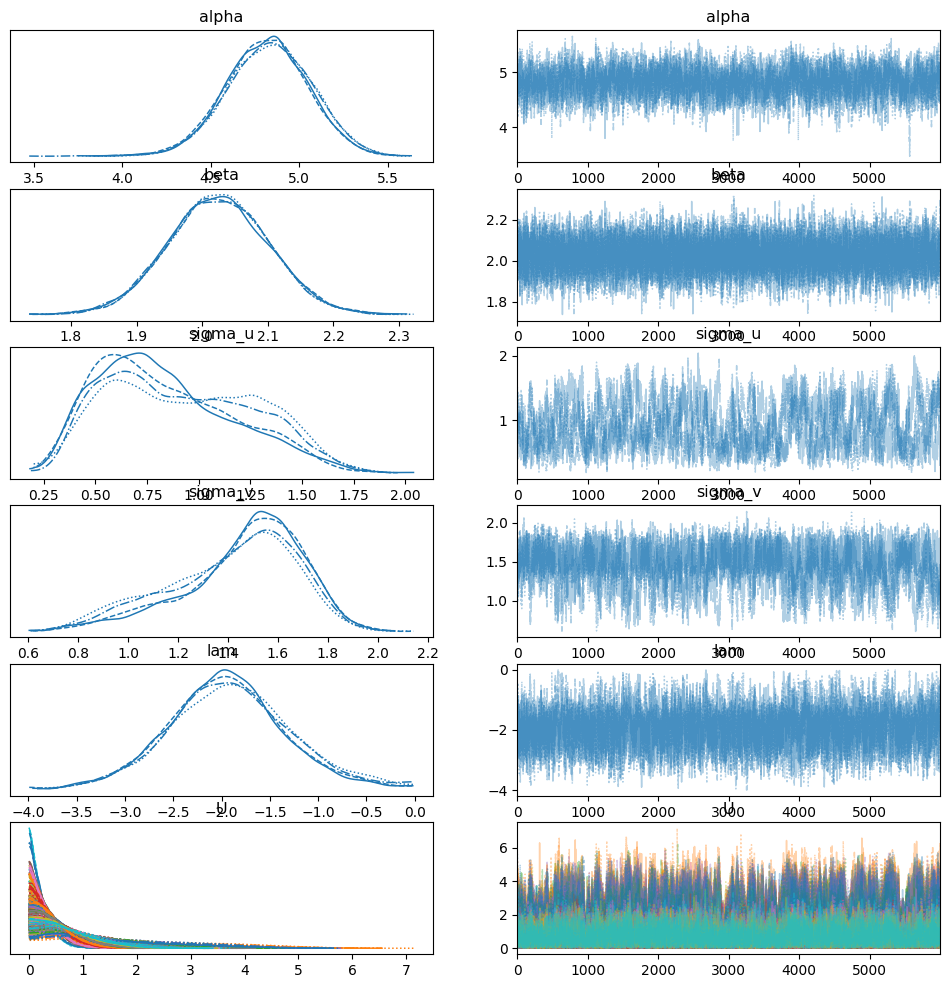

In [47]:
np.random.seed(123)

# Parameters 
n = 200
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -2

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.InverseGamma('sigma_u', 4, 3)
    sigma_v = pm.InverseGamma('sigma_v', 2.33, 3)
    lam = pm.TruncatedNormal('lam', mu=-2, sigma=1, lower=-4, upper=0)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace, round_to=2)

n = 500

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    4.91  0.13    4.65     5.13       0.01     0.00    283.66    630.24   
beta     1.95  0.04    1.87     2.02       0.00     0.00  15782.68  18217.88   
sigma_u  1.10  0.32    0.47     1.55       0.04     0.01     63.99    213.00   
sigma_v  1.13  0.25    0.72     1.55       0.03     0.01     65.56    331.00   
lam     -2.72  0.69   -4.00    -1.55       0.04     0.01    353.42   1287.47   
...       ...   ...     ...      ...        ...      ...       ...       ...   
U[495]   0.37  0.28    0.00     0.87       0.00     0.00   9710.93   9297.87   
U[496]   1.32  0.73    0.00     2.48       0.06     0.01    160.49   1258.84   
U[497]   0.43  0.31    0.00     0.99       0.01     0.00   3100.05   9392.74   
U[498]   0.75  0.47    0.00     1.54       0.02     0.00    446.81   3498.64   
U[499]   1.74  0.93    0.03     3.18       0.09     0.01    110.89    675.22   

         r_hat  
alpha     1.01  
beta      1.00  
sigma_u   1.04  
sigma_v   1.03  
lam       1.01  
...        ...  
U[495]    1.00  
U[496]    1.01  
U[497]    1.00  
U[498]    1.01  
U[499]    1.02  

[505 rows x 9 columns]

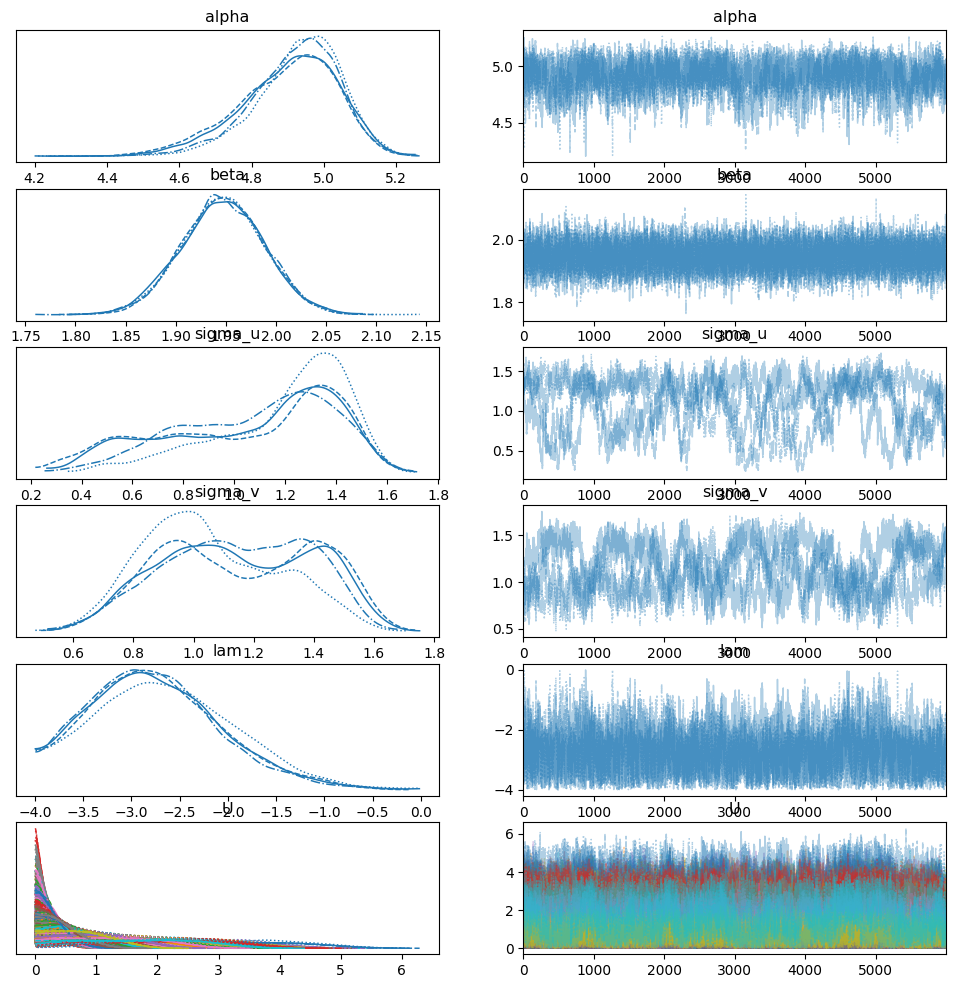

In [48]:
np.random.seed(123)

# Parameters 
n = 500
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -5

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})

with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.InverseGamma('sigma_u', 4, 3)
    sigma_v = pm.InverseGamma('sigma_v', 2.33, 3)
    lam = pm.TruncatedNormal('lam', mu=-2, sigma=1, lower=-4, upper=0)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(6000, tune=2000, target_accept=0.99, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace, round_to=2)